<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館
- input:
    - [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000021d2000000003/resource/7108f0a3-0257-424a-9722-e84999a01392)
- output:
    - library_score.csv
        - 図書館スコア

In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
output_master_file = 'library_master.csv'
output_score_file = 'library_score.csv'

In [5]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [7]:
def get_distance_from_facility(longitude, latitude, df_facility):
    return df_facility.apply(lambda x: get_distance(x['緯度'], x['経度'], longitude, latitude), axis=1)

In [8]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

In [9]:
tokyo_library_url = 'https://www.opendata.metro.tokyo.lg.jp/kyouiku/R3/skshubetu_4.csv'
df_tokyo_library = get_data_csv_url(tokyo_library_url, encoding='shift-jis')
print(df_tokyo_library.shape)

df_tokyo_library = df_tokyo_library[df_tokyo_library['施設名'].notna()]
df_tokyo_library = df_tokyo_library[(~df_tokyo_library['施設名'].str.contains('閉館'))&(df_tokyo_library['区市町村名'].str.endswith('区'))]
df_tokyo_library['施設名'] = df_tokyo_library['施設名'].str.replace('＊\?', '', regex=True).str.replace('\?\?', '', regex=True)
df_tokyo_library = df_tokyo_library.rename(columns={'施設区分':'施設分類', '施設名':'名称', '区市町村名':'市区町村名'})[extract_columns].reset_index(drop=True)
print(df_tokyo_library.shape)

(418, 9)
(233, 6)


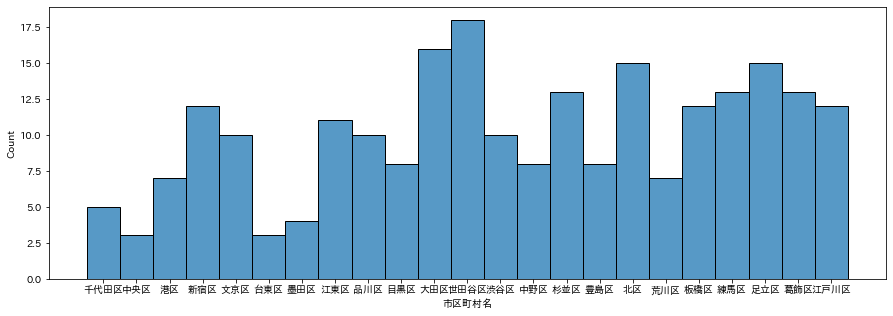

In [10]:
plt.figure(figsize=(15, 5))
sns.histplot(x='市区町村名', data=df_tokyo_library)
plt.show()

## 図書館マスタ

In [11]:
df_library_master = df_tokyo_library
df_library_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,図書館,昌平まちかど図書館,千代田区,千代田区外神田3-4-7,35.701223,139.769873
1,図書館,神田まちかど図書館,千代田区,千代田区神田司町2-16,35.693357,139.768304
2,図書館,四番町図書館,千代田区,千代田区四番町1,35.690453,139.741601
3,図書館,千代田図書館,千代田区,千代田区九段南1-2-1千代田区役所9･10階,35.693997,139.753585
4,図書館,日比谷図書文化館,千代田区,千代田区日比谷公園1-4,35.671872,139.754602


In [12]:
df_library_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

## 人口マスタ

In [13]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


In [14]:
%%time
# 一番近い施設の距離
df_pop_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'min')
# 近い3件の距離の平均
df_pop_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'mean', 3)
# 2km以内の施設の数
df_pop_master['図書館(数)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'count', 2)

CPU times: user 1min 10s, sys: 243 ms, total: 1min 10s
Wall time: 1min 16s


In [15]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 9)


,地域ID,市区町村名,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,1.286453,1.301848,5
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,1.242295,1.349516,5
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,1.000856,1.274480,4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.687988,1.136131,5
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.772108,1.182786,6


In [16]:
score_name = '図書館スコア'
feature_list = {
    '図書館(最近傍距離)':   {'sort': -1, 'weight': 1}, 
    '図書館(平均距離)':     {'sort': -1, 'weight': 0.7},
    '図書館(数)':           {'sort': 1, 'weight': 0.5}, 
}
all_feature_list = list(feature_list.keys())

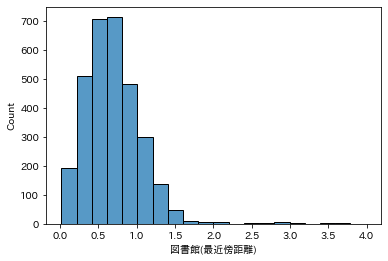

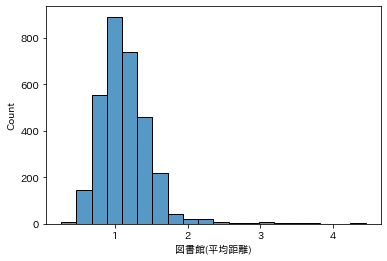

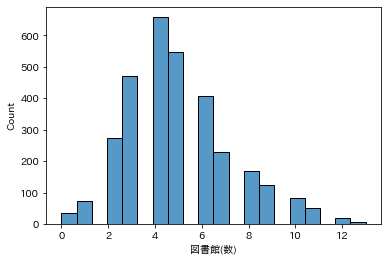

In [17]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [18]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    rank = sr_data.rank()
    count = rank.max() 
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

In [19]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

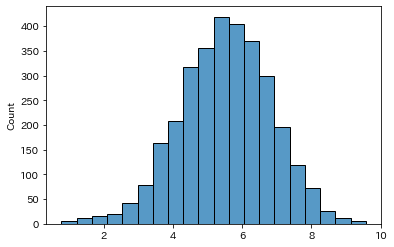

In [20]:
sns.histplot(_tmp_score, bins=20)
plt.show()

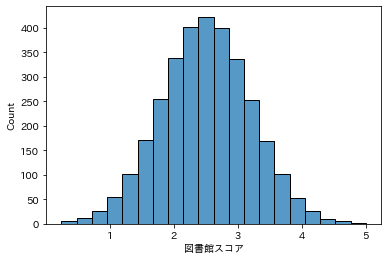

In [21]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [22]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501557
std         0.698656
min         0.244613
25%         2.028908
50%         2.500558
75%         2.972493
max         5.000000
Name: 図書館スコア, dtype: float64

In [23]:
all_feature_list

['図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']

In [24]:
df_pop_master[score_name] = df_pop_master[score_name].round(2)
for col in all_feature_list:
    df_pop_master[col] = df_pop_master[col].round(3)

In [25]:
df_pop_master[
    ['地域ID'] + all_feature_list + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

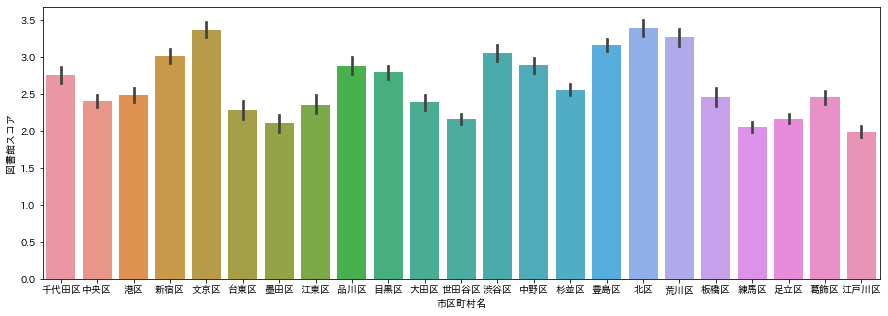

In [26]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [27]:
def get_score_top(df_data, target):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [28]:
df_level = get_score_top(df_pop_master, '図書館')
print(df_level.shape)
df_level.head(10)

(900, 7)


,市区町村名,町名,町丁目,図書館(最近傍距離),図書館(平均距離),図書館(数),図書館スコア
0,板橋区,本町,本町,0.018,0.574,10,5.00
1,北区,上中里,上中里１丁目,0.126,0.530,13,4.89
2,北区,東十条,東十条３丁目,0.026,0.577,10,4.76
3,新宿区,大久保,大久保２丁目,0.149,0.251,10,4.67
4,北区,上十条,上十条３丁目,0.082,0.572,12,4.61
5,北区,田端新町,田端新町２丁目,0.135,0.581,13,4.56
6,文京区,本駒込,本駒込４丁目,0.145,0.416,11,4.52
7,北区,田端,田端２丁目,0.127,0.435,11,4.49
8,豊島区,駒込,駒込２丁目,0.075,0.520,9,4.46
9,荒川区,西日暮里,西日暮里６丁目,0.140,0.511,11,4.41


In [29]:
df_level.tail(10)

,市区町村名,町名,町丁目,図書館(最近傍距離),図書館(平均距離),図書館(数),図書館スコア
890,江東区,有明,有明１丁目,1.430,1.826,2,1.09
891,江東区,夢の島,夢の島１丁目,1.772,2.062,2,0.99
892,大田区,京浜島,京浜島１丁目,1.860,2.156,2,0.98
893,練馬区,西大泉町,西大泉町,1.844,2.241,1,0.92
894,江東区,新木場,新木場１丁目,2.026,2.625,0,0.84
895,品川区,東八潮,東八潮,2.176,2.589,0,0.82
896,港区,台場,台場１丁目,2.609,2.817,0,0.77
897,大田区,城南島,城南島７丁目,2.819,3.039,0,0.73
898,江東区,青海,青海１丁目,2.840,3.141,0,0.69
899,江東区,若洲,若洲１丁目,2.805,3.803,0,0.61
